# Inventory Management Workflow
This notebook helps you manage your physical component inventory for KiCad projects, including manual entry, image-assisted ingestion, and LLM/LMM-powered suggestions and checks.

## 1. Load and Display Inventory
Load your inventory from `inventory.yaml` and display it as a table.

In [10]:
from inventory_manager import Inventory
from data_models.inventory_item import InventoryItem
import pandas as pd
from pathlib import Path
inv_path = Path('inventory.yaml')
inventory = Inventory(inv_path)
inventory.load()
df = inventory.to_dataframe()
df

Loaded 0 items from 'C:\Temp\KicadAutoFlow\inventory.yaml'.


,part_id,description,value,package,footprint,footprint_source,mpn,quantity,storage_location,datasheet_local,image_path


## 2. Manually Add a New Inventory Item
Fill in the fields below to add a new part to your inventory.

In [ ]:
from ipywidgets import Text, IntText, Dropdown, Button, VBox
desc = Text(description='Description')
value = Text(description='Value')
package = Text(description='Package')
footprint = Text(description='Footprint')
mounting_type = Dropdown(description='Mounting', options=['Surface Mount', 'Through-Hole', 'Unknown'], value='Unknown')
quantity = IntText(description='Quantity', value=1)
add_btn = Button(description='Add to Inventory', button_style='success')
form = VBox([desc, value, package, footprint, mounting_type, quantity, add_btn])
display(form)
def on_add_clicked(b):
    new_item = InventoryItem(
        part_id=inventory.get_next_part_id(),
        description=desc.value,
        value=value.value,
        package=package.value,
        footprint=footprint.value,
        mounting_type=mounting_type.value,
        footprint_source='manual',
        mpn=None,
        quantity=quantity.value
    )
    inventory.add_part(new_item)
    inventory.save()
    print(f'Added {new_item.part_id} to inventory.')
add_btn.on_click(on_add_clicked)

## 3. Add Inventory Item from a Picture (LMM Assisted)
Upload a photo of your part, let the LMM suggest details, review, and add it to your inventory.

In [11]:
import ipywidgets as widgets
from IPython.display import display, Image
from pathlib import Path
img_upload = widgets.FileUpload(accept='image/*', multiple=False)
display(img_upload)

FileUpload(value=(), accept='image/*', description='Upload')

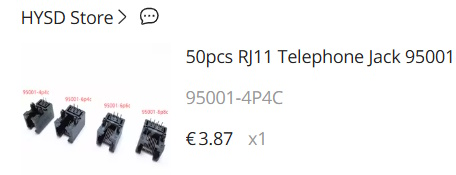

Image saved to docs\inventory_images\part.jpg


In [18]:
# Save uploaded image and display it
img_path = None
if img_upload.value:
    img_info = img_upload.value[0]
    img_bytes = img_info['content']
    img_name = img_info['name']
    img_dir = Path('docs/inventory_images')
    img_dir.mkdir(parents=True, exist_ok=True)
    img_path = img_dir / img_name
    with open(img_path, 'wb') as f:
        f.write(img_bytes)
    display(Image(filename=str(img_path)))
    print(f'Image saved to {img_path}')
else:
    print('Upload an image to continue.')

In [ ]:
# Use Gemini LMM to analyze the image, suggest part details, and find a footprint
from adk_capabilities.llm_capability import GeminiCapability
from utils.config_loader import load_config
lmm_result = {}
footprint_suggestion = None
if img_path and img_path.exists():
    config = load_config('config.yaml')
    llm = GeminiCapability(config=config)
    with open(img_path, 'rb') as f:
        img_bytes = f.read()
    # Use the built-in prompt from prompts.yaml
    lmm_result = llm.analyze_image_for_component(img_bytes) or {}
    print('LMM suggestion:', lmm_result)
    footprint_suggestion = lmm_result.get('footprint_suggestion')
else:
    print('Upload an image and rerun this cell.')

LMM suggestion: {'detected_text': 'HYSD Store, 50pcs RJ11 Telephone Jack 95001, 95001-4P4C, 95001-4p4c, 95001-6p4c, 95001-6p4c, 95001-6p4c', 'component_type_guess': 'Connector', 'package_guess': None, 'value_guess': '95001-4P4C', 'mounting_type': 'Through-Hole', 'footprint_suggestion': None, 'confidence': 'Medium'}


In [ ]:
# Pre-fill the form with LMM suggestions (user can edit)
from ipywidgets import Text, IntText, Dropdown, Button, VBox
desc = Text(description='Description', value=lmm_result.get('component_type_guess', '') or lmm_result.get('description', ''))
value = Text(description='Value', value=lmm_result.get('value_guess', '') or lmm_result.get('value', ''))
package = Text(description='Package', value=lmm_result.get('package_guess', '') or lmm_result.get('package', ''))
footprint = Text(description='Footprint', value=lmm_result.get('footprint', ''))
mounting_type = Dropdown(description='Mounting', options=['Surface Mount', 'Through-Hole', 'Unknown'], value=lmm_result.get('mounting_type', 'Unknown') or 'Unknown')
quantity = IntText(description='Quantity', value=1)
add_btn = Button(description='Add to Inventory', button_style='success')
form = VBox([desc, value, package, footprint, mounting_type, quantity, add_btn])
display(form)
def on_add_clicked(b):
    if not img_path or not img_path.exists():
        print('Please upload an image first.')
        return
    img_rel_path = str(img_path).replace('\\', '/').replace('\\', '/')
    new_item = InventoryItem(
        part_id=inventory.get_next_part_id(),
        description=desc.value,
        value=value.value,
        package=package.value,
        footprint=footprint.value,
        mounting_type=mounting_type.value,
        footprint_source='lmm' if lmm_result else 'manual',
        mpn=None,
        quantity=quantity.value,
        image_path=img_rel_path
    )
    inventory.add_part(new_item)
    inventory.save()
    print(f'Added {new_item.part_id} to inventory.')
add_btn.on_click(on_add_clicked)

## 4. Suggest a Footprint for a Component (LLM)
Use the LLM to suggest a KiCad footprint for a given component description and package.

In [ ]:
# Suggest a footprint using the LLM
from adk_capabilities.llm_capability import GeminiCapability
from utils.config_loader import load_config
config = load_config('config.yaml')
llm = GeminiCapability(config=config)
component_desc = input('Component description: ')
package_desc = input('Package description: ')
footprint_suggestion = llm.suggest_footprint(package_desc, component_desc)
print('Suggested KiCad Footprint:', footprint_suggestion)

## 5. Check Datasheet Pin Count and Package Consistency (LLM)
Use the LLM to check if a datasheet snippet matches the expected pin count and package.

In [ ]:
# Add the new item to inventory when button is clicked
def on_add_clicked(b):
    if not img_path or not img_path.exists():
        print('Please upload an image first.')
        return
    img_rel_path = str(img_path).replace('\\', '/').replace('\\', '/')
    new_item = InventoryItem(
        part_id=inventory.get_next_part_id(),
        description=desc.value,
        value=value.value,
        package=package.value,
        footprint=footprint.value,
        mounting_type=mounting_type.value,
        footprint_source='lmm' if lmm_result else 'manual',
        mpn=lmm_result.get('mpn', None),
        quantity=quantity.value,
        image_path=img_rel_path
    )
    inventory.add_part(new_item)
    inventory.save()
    print(f'Added {new_item.part_id} to inventory.')
add_btn.on_click(on_add_clicked)